<a href="https://colab.research.google.com/github/Hchama/Final_Thesis/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch pytorch-cpu torchvision
!pip install fastai --upgrade
!pip install transformers
import fastai
from fastai.vision.all import *
from fastai.callback.tracker import  EarlyStoppingCallback
from fastai.callback.schedule import lr_find, LRFinder
from PIL import Image

#custom vit model
from transformers import AutoModel, AutoTokenizer

# Increase the maximum limit
Image.MAX_IMAGE_PIXELS = None  # or a large number, e.g., 1000000000

  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement pytorch-cpu (from versions: none)
ERROR: No matching distribution found for pytorch-cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.3 MB/s et

In [ ]:
path = '/content/drive/MyDrive/Proj'  # adjust this to your path
data = ImageDataLoaders.from_folder(path, train='train', valid='validation', item_tfms=Resize(460), batch_tfms=aug_transforms(size=224, min_scale=0.75), bs=32)

In [ ]:
import os

# List first 10 files in the training directory
train_files = os.listdir('/content/drive/MyDrive/Proj/train')
print(train_files[:10])

# List first 10 files in the testing directory
test_files = os.listdir('/content/drive/MyDrive/Proj/test')
print(test_files[:10])


['Authentic', 'Artificial']
['a8-ai.jpg', 'a14-ai.jpg', 'a9-ai.jpg', 'a23-ai.jpg', 'a12-ai.jpg', 'a33-ai.jpg', 'a17-ai.jpg', 'a6-ai.png', 'a34-ai.jpg', 'a10-ai.jpg']


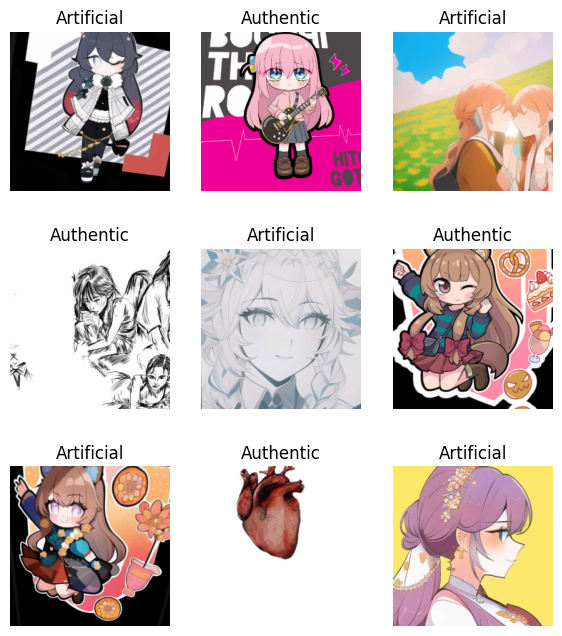

In [ ]:
data.show_batch(nrows=3, figsize=(7,8))

In [ ]:
#custom vit model

model_name = "google/vit-base-patch16-224-in21k"
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
except:
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

vit_model = AutoModel.from_pretrained(model_name)

class ViTImageModel(Module):
    def __init__(self, vit_model):
        self.vit_model = vit_model

    def forward(self, x):
        output = self.vit_model(x)
        return output.last_hidden_state[:, 0, :]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,4.757553,3.160336,0.583333,0.166667,1.000000,0.285714,02:11
1,3.489558,2.618555,0.547619,0.095238,1.000000,0.173913,01:41
2,2.788316,2.012579,0.714286,0.476190,0.909091,0.625000,01:40
3,2.391987,1.927586,0.654762,0.547619,0.696970,0.613333,01:39
4,2.125165,1.795220,0.535714,0.071429,1.000000,0.133333,01:32
5,1.878202,1.650382,0.595238,0.238095,0.833333,0.370370,01:39
6,1.611609,1.149716,0.666667,0.714286,0.652174,0.681818,01:39
7,1.352889,1.094727,0.654762,0.523810,0.709677,0.602740,01:39
8,1.157835,0.963478,0.726190,0.619048,0.787879,0.693333,01:38
9,0.988531,1.159008,0.619048,0.809524,0.586207,0.680000,01:40


No improvement since epoch 15: early stopping


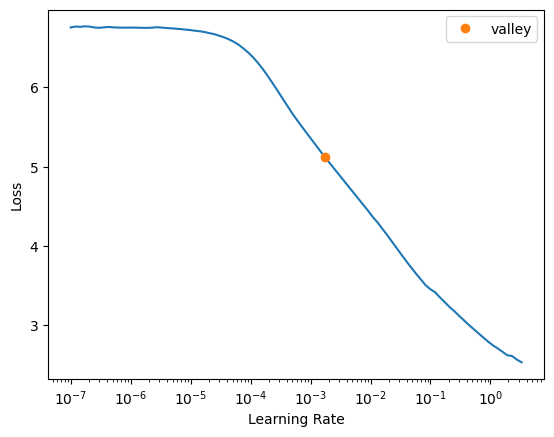

In [ ]:
learn = Learner(data, ViTImageModel(vit_model), opt_func=Adam, lr=0.001, metrics=[accuracy, Recall(), Precision(), F1Score()])

# Early stopping callback
early_stopping = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)
learn.add_cb(early_stopping)

learn.lr_find()

learn.fit_one_cycle(20, slice(1e-4, 1e-3))

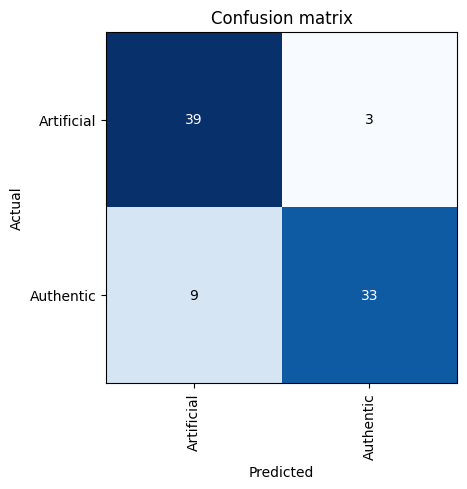

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
folder_path = "/content/drive/MyDrive/Proj/test/"

authentic_count = 0
artificial_count = 0
incorrect_authentic_count = 0
incorrect_artificial_count = 0
correct_count = 0
incorrect_count = 0

# Finds the numnber of correct/incorrect classified images
for file_name in os.listdir(folder_path):
    if file_name.endswith(".jpg") or file_name.endswith(".png"):
        img = PILImage.create(os.path.join(folder_path, file_name))

        pred_class, _, _ = learn.predict(img)

        print(f"File: {file_name}, Predicted Class: {pred_class}")

        true_class = "Artificial" if file_name.endswith("-ai.jpg") else "Authentic"
        if pred_class == true_class:
            correct_count += 1
            if true_class == "Authentic":
                authentic_count += 1
            else:
                artificial_count += 1
        else:
            incorrect_count += 1
            if true_class == "Authentic":
                incorrect_authentic_count += 1
            else:
                incorrect_artificial_count += 1

print(f"Number of images correctly predicted: {correct_count}")
print(f"Number of images incorrectly predicted: {incorrect_count}")
print(f"Number of authentic images: {authentic_count}")
print(f"Number of artificial images: {artificial_count}")
print(f"Number of incorrectly predicted authentic images: {incorrect_authentic_count}")
print(f"Number of incorrectly predicted artificial images: {incorrect_artificial_count}")

File: a8-ai.jpg, Predicted Class: Artificial


File: a14-ai.jpg, Predicted Class: Artificial


File: a9-ai.jpg, Predicted Class: Artificial


File: a23-ai.jpg, Predicted Class: Artificial


File: a12-ai.jpg, Predicted Class: Artificial


File: a33-ai.jpg, Predicted Class: Artificial


File: a17-ai.jpg, Predicted Class: Artificial


File: a6-ai.png, Predicted Class: Authentic


File: a34-ai.jpg, Predicted Class: Artificial


File: a10-ai.jpg, Predicted Class: Authentic


File: a28-ai.jpg, Predicted Class: Artificial


File: a7-ai.jpg, Predicted Class: Artificial


File: a24-ai.jpg, Predicted Class: Authentic


File: a19-ai.jpg, Predicted Class: Artificial


File: a18-ai.jpg, Predicted Class: Artificial


File: a1-ai.png, Predicted Class: Authentic


File: a26-ai.jpg, Predicted Class: Artificial


File: a4-ai.png, Predicted Class: Authentic


File: a37-ai.jpg, Predicted Class: Artificial


File: a40-ai.jpg, Predicted Class: Artificial


File: a16-ai.jpg, Predicted Class: Artificial


File: a30-ai.jpg, Predicted Class: Artificial


File: a31-ai.jpg, Predicted Class: Artificial


File: a22-ai.jpg, Predicted Class: Artificial


File: a39-ai.jpg, Predicted Class: Artificial


File: a11-ai.jpg, Predicted Class: Artificial


File: a3-ai.png, Predicted Class: Authentic


File: a20-ai.jpg, Predicted Class: Artificial


File: a41-ai.jpg, Predicted Class: Artificial


File: a35-ai.jpg, Predicted Class: Artificial


File: a2-ai.jpg, Predicted Class: Artificial


File: a21-ai.jpg, Predicted Class: Artificial


File: a25-ai.jpg, Predicted Class: Artificial


File: a15-ai.jpg, Predicted Class: Artificial


File: a36-ai.jpg, Predicted Class: Artificial


File: a6.jpg, Predicted Class: Authentic


File: a13.jpg, Predicted Class: Authentic


File: a29-ai.jpg, Predicted Class: Authentic


File: a13-ai.jpg, Predicted Class: Artificial


File: a4.jpg, Predicted Class: Authentic


File: a10.jpg, Predicted Class: Authentic


File: a9.jpg, Predicted Class: Authentic


File: a2.jpg, Predicted Class: Artificial


File: a27-ai.jpg, Predicted Class: Artificial


File: a42-ai.jpg, Predicted Class: Artificial


File: a17.jpg, Predicted Class: Artificial


File: a32-ai.jpg, Predicted Class: Artificial


File: a5-ai.jpg, Predicted Class: Authentic


File: a11.jpg, Predicted Class: Authentic


File: a38-ai.jpg, Predicted Class: Artificial


File: a16.jpg, Predicted Class: Authentic


File: a12.jpg, Predicted Class: Authentic


File: a14.jpg, Predicted Class: Authentic


File: a40.jpg, Predicted Class: Authentic


File: a7.jpg, Predicted Class: Authentic


File: a34.jpg, Predicted Class: Authentic


File: a39.jpg, Predicted Class: Authentic


File: a35.jpg, Predicted Class: Authentic


File: a36.jpg, Predicted Class: Authentic


File: a26.jpg, Predicted Class: Authentic


File: a29.jpg, Predicted Class: Artificial


File: a5.jpg, Predicted Class: Authentic


File: a18.jpg, Predicted Class: Artificial


File: a1.jpg, Predicted Class: Authentic


File: a38.jpg, Predicted Class: Artificial


File: a15.jpg, Predicted Class: Artificial


File: a21.jpg, Predicted Class: Authentic


File: a28.jpg, Predicted Class: Authentic


File: a30.jpg, Predicted Class: Artificial


File: a22.jpg, Predicted Class: Artificial


File: a24.jpg, Predicted Class: Artificial


File: a8.jpg, Predicted Class: Authentic


File: a20.jpg, Predicted Class: Authentic


File: a23.jpg, Predicted Class: Artificial


File: a19.jpg, Predicted Class: Authentic


File: a31.jpg, Predicted Class: Authentic


File: a32.jpg, Predicted Class: Artificial


File: a3.jpg, Predicted Class: Authentic


File: a25.jpg, Predicted Class: Artificial


File: a33.jpg, Predicted Class: Artificial


File: a37.jpg, Predicted Class: Authentic


File: a42.jpg, Predicted Class: Artificial


File: a41.jpg, Predicted Class: Artificial


File: a27.jpg, Predicted Class: Authentic
Number of images correctly predicted: 65
Number of images incorrectly predicted: 19
Number of authentic images: 31
Number of artificial images: 34
Number of incorrectly predicted authentic images: 15
Number of incorrectly predicted artificial images: 4


In [ ]:
#Testing results
TP = authentic_count
TN = artificial_count
FP = incorrect_authentic_count
FN = incorrect_artificial_count

Total = TP + TN + FP + FN

accuracy = (TP + TN) / Total

precision = TP / (TP + FP)

recall = TP / (TP + FN)

f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1_score: {f1_score}")

Accuracy: 0.7738095238095238
precision: 0.6739130434782609
recall: 0.8857142857142857
f1_score: 0.7654320987654321
